## Imports: standard libraries, data processing, visualization, ML/DL


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, classification_report, silhouette_score, precision_recall_curve, auc
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from pandas.plotting import parallel_coordinates
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping


# %matplotlib inline

## Loading and Preprocessing IMDB Dataset
Download the IMDB movie reviews dataset, convert text to integer sequences, and pad sequences to a fixed length for the LSTM input.


In [12]:
#first download data from imdb
padding_length = 2000
review_size = 20000 #set an upper limit on the length of review as a feature
def load_and_preprocess_imdb(num_words=review_size, seq_len=padding_length):
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
    X_train = pad_sequences(X_train, maxlen=seq_len, padding="post", truncating="post")
    X_test = pad_sequences(X_test, maxlen=seq_len, padding="post", truncating="post")
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_and_preprocess_imdb()

#the data is preprocessed, each integer represents a word
#pad the reviews to fix the data length for the neural network



## Perform embedding and also build the LSTM model

In [13]:
def build_LSTM():
    LSTM_model = keras.Sequential([Input(shape=(padding_length,)),
        Embedding(input_dim=review_size, output_dim=128, input_length=padding_length),
        
    # Bidirectional wrapper processes sequence in both directions
    Bidirectional(LSTM(units=128, 
                       return_sequences=False,
                       dropout=0.25,         # Regularization
                       recurrent_dropout=0.25)),
    
    # Fully connected layer
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),                               
                                   
    # Output layer
    Dense(1, activation='sigmoid')
      ])
    
    LSTM_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])
    
    return LSTM_model

LSTM_model = build_LSTM()
LSTM_model.summary()

/home/devanshu/jupyter_env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 2000, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,848,001 (10.86 MB)

 Trainable params: 2,848,001 (10.86 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Bi-LSTM Model
Define early stopping to prevent overfitting, train the LSTM model, and plot training/validation accuracy and loss curves.

In [16]:
def train_model(model, X_train, y_train, batch_size=128, epochs=10, patience=3):
    early_stop_cb = EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        # validation_data=(X_val, y_val),
        validation_split=0.2,
        epochs=epochs, batch_size=batch_size,
        callbacks=[early_stop_cb], verbose=1
    )
    return history

training_LSTM = train_model(LSTM_model, X_train, y_train)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.6008 - loss: 0.6578
Epoch 2/10


/home/devanshu/jupyter_env/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


196/196 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.8210 - loss: 0.4160
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9274 - loss: 0.2098
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9586 - loss: 0.1293
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9773 - loss: 0.0766
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9868 - loss: 0.0437
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9910 - loss: 0.0299
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.9927 - loss: 0.0237
Epoch 9/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.9951 - loss: 0.0167
Epoch 10/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9724 - loss: 0.0593


KeyError: 'val_accuracy'

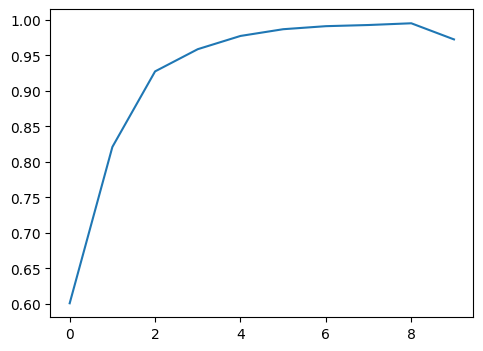

In [17]:
stop_early = EarlyStopping(monitor="val_loss", patience=1) #patience sets the number of epochs of no change in val_loss to wait

#train the LSTM model

training_LSTM = LSTM_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose=1, callbacks=[stop_early])#, callbacks=[stop_early]

#visualize the results of training
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(training_LSTM)

## Threshold Tuning for Classification
Analyze precision-recall tradeoffs and adjust the decision threshold to optimize model performance.


782/782 ━━━━━━━━━━━━━━━━━━━━ 359s 458ms/step


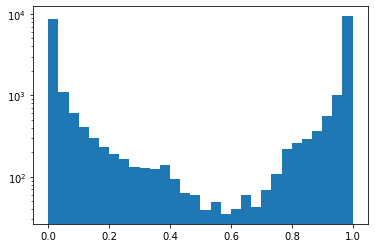

In [5]:
#Tune the threshold for separating positive and negative reviews
#check and compute the class imbalance
#higher precision pushes the threshold to higher values
#higher recall pulls the threshold to lower values

y_train_probability = LSTM_model.predict(X_train).ravel()
plt.hist(y_train_probability,log=True, bins=30)

def set_threshold(switch):
    precision, recall, thresholds = precision_recall_curve(y_train, y_train_probability)

    #maximize the F1 score to achieve precision--recall balance
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_threshold_f1 = thresholds[np.argmax(f1_scores)]
    print(f"Optimal threshold for maximized F1 score: {optimal_threshold_f1:.3f}")

    #Other approach to compute optimal threshold
    #try to aim for as high precision as possible, avoid false positives
    precision_goal = 0.95
    optimal_threshold_precision = thresholds[np.where(precision >= precision_goal)[0][0]]
    print(f"Optimal threshold for higher precision: {optimal_threshold_precision:.3f}")
    
    #cost function approach to compute optimal threshold
    cost_fp = 2.0  # Cost of false positive
    cost_fn = 1.0   # Cost of false negative
    #essentially, penalize false positive more
    # Minimize expected cost
    expected_cost = (cost_fp * (1 - precision) + cost_fn * (1 - recall))
    optimal_idx = np.argmin(expected_cost)
    optimal_threshold_costFn = thresholds[optimal_idx]
    print(f"Cost-optimal threshold: {optimal_threshold:.3f}")
    
    if switch=="f1":
        return optimal_threshold_f1
    elif switch=="precision":
        return optimal_threshold_precision
    elif switch=="cost_func":
        return optimal_threshold_costFn
    else:
        return 0.5




## Evaluating the Model on Test Data
Measure model accuracy and loss on unseen test data, and define a function to decode reviews from their numerical representation back to text.


In [18]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    print(f'Accuracy: {accuracy:.4f}')
    # Add confusion matrix, classification report, etc.

evaluate_model(LSTM_model, X_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 280s 357ms/step
Accuracy: 0.8590


## Function for Predicting the Sentiments
Create a structure to decrypt the encrypted review and feed it to the LSTM model to make predictions

In [6]:
#predict the test dataset results
# score_LSTM = LSTM_model.evaluate(X_test, y_test, verbose=0)
# print("Test Loss:", score_LSTM[0])
# print("Test Accuracy:", score_LSTM[1])

#predict the category using the below function

#first create the mapping from word to digits
char_digit = imdb.get_word_index()
digit_char_index = {a:b for b,a in char_digit.items()} 

def review_decrypt(encrypted_review): #takes in the encrypted vectorized review and decodes it to human readable format
    return ' '.join([digit_char_index.get(i-3, '?') for i in encrypted_review])

def review_predict(text):
#     text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    # Step 1: Tokenize text (split into words and convert to lowercase)
    tokens = tf.keras.preprocessing.text.text_to_word_sequence(text, lower=True)
    
    
    # Step 2: Convert words to integers using IMDB's word index
    tokens = [char_digit.get(word, 0) for word in tokens]  # 0 = unknown word
    tokens = [min(idx, review_size - 1) for idx in tokens]  # Force indices to be < vocab_size
#     print(type(tokens))
    # Step 3: Pad/truncate to match model's input length (500)
    padded = pad_sequences([tokens], maxlen=padding_length, padding='post', truncating='post')
#     print(type(padded))
    # Step 4: Predict sentiment (output is between 0 and 1)
    pred = LSTM_model.predict(padded, verbose=0)[0][0]
        # Step 5: Interpret prediction
    sentiment = "Positive" if pred >= set_threshold("f1") else "Negative"
    confidence = pred #if pred > 0.5 else 1 - pred
    
    return f"{sentiment} (Confidence: {confidence:.2f})"



Test Loss: 0.3781123757362366
Test Accuracy: 0.854200005531311


## Predicting Sentiment for Custom Reviews
Test the trained model on custom-written reviews to check if predictions align with expectations.


In [7]:
# custom_reviews = [
#     "good movie",
#     "worst worst worst movie",
#     "this movie was fantastic! the acting was brilliant.",
#     "terrible plot and awful acting waste of time.",
#     "it was okay, but the ending could have been better.",
#     "the plot was boring and the acting was terrible",
#     "do not waste your money on this movie"
# ]



custom_reviews = [
   "Christopher Nolan’s The Dark Knight redefines the superhero genre with its gripping narrative, intense action, and Heath Ledger’s iconic performance as the Joker. The film balances psychological depth with blockbuster spectacle, exploring themes of chaos and morality. Hans Zimmer’s score elevates every scene, and the pacing never falters. Minor flaws? Some may find the runtime long, but it’s a small price for such a rich story. A timeless classic.",
    "James Cameron’s Avatar delivers groundbreaking visuals but suffers from a clichéd plot and shallow characters. The world-building is impressive, yet the story feels like a rehash of Pocahontas in space. Dialogue is often cringe-worthy. Worth watching once for the spectacle, but it doesn’t hold up on repeat viewings.",
    "Pixar’s Toy Story 3 tugs at heartstrings with its emotional depth and clever humor. The animation is flawless, and the themes of growing up resonate universally. The climax in the incinerator is one of cinema’s most tense moments. Only gripe? Some jokes feel recycled from earlier films. Still, a near-perfect trilogy finale.",
    "Tommy Wiseau’s The Room is a trainwreck of incoherent plotting, wooden acting, and baffling production choices. The dialogue feels AI-generated, and the green-screen backdrops are laughable. Yet, its sheer incompetence has spawned a cult following. Watch with friends for ironic laughs—alone, it’s unbearable.",
    "Nolan’s Inception dazzles with its dream-within-a-dream concept and stunning visuals (e.g., the rotating hallway fight). However, the emotional core feels underdeveloped—Cobb and Mal’s relationship lacks depth. The supporting cast (Hardy, Page) shines, but some characters are thinly written. A technical marvel that prioritizes intellect over heart.",
    "A visually stunning but emotionally uneven sci-fi epic. Nolan’s ambition shines in the cosmic visuals and theoretical physics, but the pacing drags in the second act. McConaughey’s performance anchors the film, though some dialogue feels overly expository. The ending polarizes audiences—some find it profound, others contrived.",
    "A joyous celebration of classic Hollywood musicals with vibrant colors, catchy songs, and Gosling/Stone’s electric chemistry. The finale’s bittersweet twist elevates it beyond genre tropes. Minor quibble: Some dance sequences feel under-rehearsed.",
    "A bloated, incoherent mess of explosions and product placements. The plot is nonsensical, characters are cardboard cutouts, and the runtime (165 minutes!) is unforgivable. Only worth watching for unintentional comedy.",
    "A relentless, adrenaline-fueled masterpiece. Simmons’ terrifying performance and the blistering jazz sequences create unbearable tension. The finale is cathartic perfection. Not for the faint-hearted—this film demands your full attention.",
    "Fun but forgettable. The dinosaur action delivers spectacle, but the characters are bland and the plot rehashes Jurassic Park beats. Pratt’s charm saves it from being a total waste."
]

for review in custom_reviews:
#     print(f"Review: {review[:60]}...")
    print(f"Prediction: {review_predict(review)}\n")

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Positive (Confidence: 0.98)

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Positive (Confidence: 0.95)

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Positive (Confidence: 0.99)

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Negative (Confidence: 0.34)

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Positive (Confidence: 1.00)



In [19]:
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'recall' is not defined